## BBC News Classification Kaggle Mini-Project

This Kaggle competition is about categorizing news articles. You will use matrix factorization to predict the category and submit your notebook for peer evaluation. 

The part has 80 points. The instructions summarize the criteria you will use to guide your submission and review others’ submissions. 
Use Matrix Factorization to predict the category and submit your notebook for peer evaluation.



### Instructions: Step 1 - Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Please feel free to look at online resources on processing raw texts to feature vectors. Many methods process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a method and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words. Also, do exploratory data analysis such as word statistics and/or visualization.

As we did not learn natural language processing (NLP) specific techniques such as word embeddings in the lectures, we recommend reading discussions and example codes from others in the Kaggle and/or doing some research online to make sure you understand. You can refer to any resource as needed, but make sure you “demonstrate” your understanding- please include explaining in your own words, discussions, and your interpretation. Also importantly, please have a reference list at the end of the report. 

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### Read Train and Test Data

In [57]:
# Read the training data
df_train = pd.read_csv('./Data/BBC News Train.csv')
# Read the test data
df_test = pd.read_csv('./Data/BBC News Test.csv')

df_train.info()
df_train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


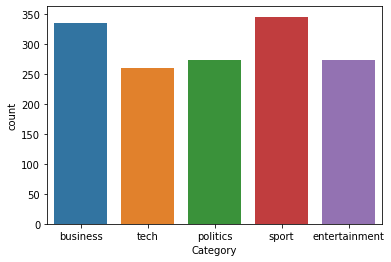

In [58]:
# Plot the distribution of the target variable
sns.countplot(df_train['Category'])
plt.show()


There are 5 categories : Business, Tech, Politics , Sports and Entertainment in Training Set.

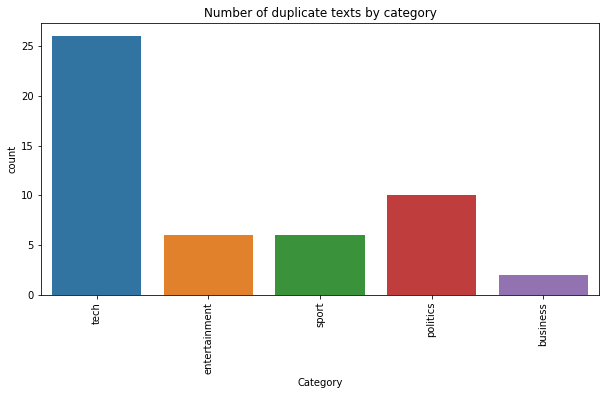

Total number of duplicate texts:  50


In [59]:

# Get the duplicate texts
dup_text = df_train[df_train.duplicated(subset=['Text'], keep=False)].sort_values(by='Text').head(50)
# Plot the number of duplicate text by category
plt.figure(figsize=(10, 5))
# Title of the plot
plt.title('Number of duplicate texts by category')
sns.countplot(x='Category', data=dup_text)
plt.xticks(rotation=90)
plt.show()

# Total number of duplicate texts
print('Total number of duplicate texts: ', len(dup_text))



The training data has 1490 observations and 3 columns : Articleid, Text and Category. The Articleid is unique. There are 50 duplicate texts in training data.
Above bar chart shows duplicate text by category.

In [60]:
# Remove the duplicate texts
df_train.drop_duplicates(subset=['Text'], keep='first', inplace=True)
# Reset the index
df_train.reset_index(drop=True, inplace=True)

# Print the shape of the training data
print('Shape of the training data: ', df_train.shape)

Shape of the training data:  (1440, 3)


Let's examine sample data from "Text" column. We want to ensure that the data has english words without any common words (stop words), special characters, comma's, punctuations etc.


In [69]:
# Print text of the first row
df_train['Text'][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

There are special characters, full stops, numbers etc. Also lot of stop words e.g "to" , "and" etc. We don't want to skew results by including these characters in the model.

We will use Python's Natulral Language Toolkit (nltk) : https://www.nltk.org/ , to analyze text data. 

In [70]:
# Write function to clean the text
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

def clean_text(text):
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert all characters to lowercase
    text = text.lower()
    # Split the text into words
    text = text.split()
    # Remove stopwords
    text = [word for word in text if not word in set(stopwords.words('english'))]
    # Stem the words
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]
    # Join the words
    text = ' '.join(text)
    return text

# Clean the text
df_train['Text'] = df_train['Text'].apply(clean_text)
df_test['Text'] = df_test['Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /Users/kgb-
[nltk_data]     mini/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Now that we cleaned text. Next step is to tokenize and lemmatize data. We will use NLTK to tokenize each article into a list of words. To tokenize, we use 'word_tokenize'
function from NLTK.

Lemmatization is a process of reducing each work to its base or dictionary form. For example, the words "running" and "ran" would both be reduce to the base form run. 


Ensure to install NLTK Data using following commend in macos
python3 -m nltk.downloader popular

In [76]:
# Tokenize and lemmatising the text
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')

def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize the text
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in tokens]
    # Join the words
    text = ' '.join(text)
    return text

# Lemmatize the text
df_train['Text'] = df_train['Text'].apply(lemmatize_text)
df_test['Text'] = df_test['Text'].apply(lemmatize_text)

# Print the first row of the training data
df_train['Text'][0]


[nltk_data] Downloading package wordnet to /Users/kgb-
[nltk_data]     mini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kgb-mini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'worldcom ex bos launch defenc lawyer defend former worldcom chief berni ebber batteri fraud charg call compani whistleblow first wit cynthia cooper worldcom ex head intern account alert director irregular account practic u telecom giant warn led collaps firm follow discoveri bn bn account fraud mr ebber plead guilti charg fraud conspiraci prosecut lawyer argu mr ebber orchestr seri account trick worldcom order employe hide expens inflat revenu meet wall street earn estim m cooper run consult busi told juri new york wednesday extern auditor arthur andersen approv worldcom account earli said andersen given green light procedur practic use worldcom mr ebber lawyer said unawar fraud argu auditor alert problem m cooper also said sharehold meet mr ebber often pa technic question compani financ chief give brief answer prosecut star wit former worldcom financi chief scott sullivan said mr ebber order account adjust firm tell hit book howev m cooper said mr sullivan mention anyth uncomfort wor

##### Original Text
------------------------------------------------------------------------------------------------------------------------------------
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud.



##### After Lemmanization
------------------------------------------------------------------------------------------------------------------------------------

worldcom ex bos launch defenc lawyer defend former worldcom chief berni ebber batteri fraud charg call compani whistleblow first wit cynthia cooper worldcom ex head intern account alert director irregular account practic


### Instructions: Step 2  - Building and Training Models [35 pts]

In the Kaggle competition, the training data has labels (category). Thus, it can be solved using supervised learning. In general, the more labeled data we have, the more accurate the supervised learning model will be. But unsupervised learning can be powerful even when there is a small number of labels or no labels. This assignment will apply an unsupervised approach, especially the matrix factorization method, to discover topics in the news articles and use the labels to check the accuracy.

Here are some steps to guide this section: 
1) Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?
2) Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.
3) Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle. 
4) Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.
5) Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc. 

In [82]:
# Use TF-IDF to vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer
# Create an instance of the TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
# Fit the vectorizer to the training data
tfidf.fit(df_train['Text'])
# Transform the training data
X_train = tfidf.transform(df_train['Text'])
# Transform the test data
X_test = tfidf.transform(df_test['Text'])

# Print the shape of the training data
print('Shape of the training data: ', X_train.shape)
# Print the shape of the test data
print('Shape of the test data: ', X_test.shape)


Shape of the training data:  (1440, 1000)
Shape of the test data:  (735, 1000)


<1440x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 96482 stored elements in Compressed Sparse Row format>

### Instructions: Step 3  - Compared with Supervised Learning [30 pts]

Use the following steps to guide your work:

1) Pick and train a supervised learning method(s) and compare the results (train and test performance)
2) Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?

### Instructions: Step 4  - High-Quality, Organized Jupyter Notebook Report

This project gives you hands-on experience on Kaggle, a famous platform for data science competitions. To further your professional development, think of your peers as work colleagues. An essential part of this project is the Peer Review. 